In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability as tfp
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from joblib import Parallel, delayed

In [2]:
def get_R(u, v):
    assert len(u) == len(v)
    
    d= len(u)
    
    sum_ = u+v
    sum_ = sum_[:, np.newaxis]
    num = sum_ @ sum_.T
    den = sum_.T @ sum_
    
    R = 2 * (num / den) - np.eye(d)
    
    return R

In [3]:
u = np.array([0,1])
v= np.array([1,0])

R = get_R(u,v)

R @ u

array([1., 0.])

In [4]:
from sklearn.metrics import balanced_accuracy_score as bas

def FLD_experiment(n=10, m=20, d=2, T=2, k=100):
    mean = np.zeros(d)
    mean[0] = 1
            
    vmf = tfp.distributions.VonMisesFisher(mean, k)
    dir_vectors = np.array(vmf.sample(T))
    
    R_list = [get_R(mean, dir_vec) for dir_vec in dir_vectors]
    
    means = [mean @ R for R in R_list]
    
    ldas = []
    
    n0 = n // 2
    n1 = n - n0
    
    I = np.eye(d)
        
    X = np.vstack([np.random.multivariate_normal(means[0], I, size=n0), 
                        np.random.multivariate_normal(-1 * means[0], I, size=n1)
                       ])
    y = np.hstack([np.zeros(n0), np.ones(n1)])
    
    lda = LDA()
    lda.fit(X,y)
    ldas.append(lda)
    
    del X, y
        
    m0 = m // 2
    m1 = m - m0
    for i, mean in enumerate(means[1:]):
        

        X = np.vstack([np.random.multivariate_normal(mean, I, size=m0), 
                            np.random.multivariate_normal(-1 * mean, I, size=m1)
                           ])
        y = np.hstack([np.zeros(m0), np.ones(m1)])
        
        lda = LDA()
        lda.fit(X,y)
        ldas.append(lda)

        del X, y
        
    accuracies = np.zeros(3)
    
    X = np.vstack([np.random.multivariate_normal(means[0], I, size=1000), 
                        np.random.multivariate_normal(-1 * means[0], I, size=1000)
                       ])
    y = np.hstack([np.zeros(1000), np.ones(1000)])
    
    in_posteriors = ldas[0].predict_proba(X)
    accuracies[0] = bas(y, np.argmax(in_posteriors, axis=1))
    
    all_out_posteriors = np.zeros((T-1, 2*1000, 2))
    for j, lda in enumerate(ldas[1:]):
        all_out_posteriors[j] = lda.predict_proba(X)
        
    out_posteriors = np.mean(all_out_posteriors, axis=0)
    accuracies[1] = bas(y, np.argmax(out_posteriors, axis=1))
    
    oracle_alpha = 0
    oracle_acc = accuracies[1]
    for alpha in np.arange(0.001, 1.001, step=0.001):
        posteriors = np.average([in_posteriors, out_posteriors], weights=[alpha, 1-alpha], axis=0)
        
        acc = bas(y, np.argmax(posteriors, axis=1))
        
        if acc > oracle_acc:
            oracle_alpha=alpha
            oracle_acc=acc
            
    accuracies[2] = oracle_acc
    
    return accuracies

In [5]:
from tqdm import tqdm
np.random.seed(1)

m=20
kappa=10

n_list=np.array([10,20,40])
T_list= np.array([2,6,11,21])
d_list = np.array([2,5,10,20,50,100])

n_mc=1000
n_jobs=30

accuracies = np.zeros((len(n_list), len(T_list), len(d_list), 3, n_mc))

for i, n in enumerate(tqdm(n_list)):
    for j, T in enumerate(T_list):
        for k, d in enumerate(d_list):
            f = lambda x: FLD_experiment(n,m,d,T,kappa)

            accuracies[i,j,k] = np.array(Parallel(n_jobs=n_jobs)(delayed(f)(x) for x in np.zeros(n_mc))).T

  0%|                                                                                             | 0/3 [00:00<?, ?it/s]2022-07-15 16:59:08.201883: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-15 16:59:08.205549: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-15 16:59:08.206743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-15 16:59:08.206772: I tensorflow/stream_executor/cuda/

2022-07-15 16:59:08.403157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-15 16:59:08.403195: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-15 16:59:08.403394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-15 16:59:08.403417: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-15 16:59:08.403408: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

2022-07-15 16:59:10.568315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-15 16:59:10.568380: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-15 16:59:10.568415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hayden-bci-2): /proc/driver/nvidia/version does not exist
2022-07-15 16:59:10.568802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-15 16:59:10.579073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

2022-07-15 16:59:11.116660: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-15 16:59:11.116710: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-15 16:59:11.116740: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hayden-bci-2): /proc/driver/nvidia/version does not exist
2022-07-15 16:59:11.117100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-15 16:59:11.119379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

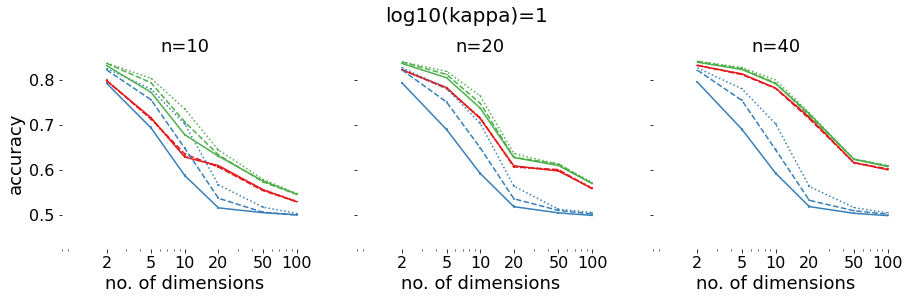

In [11]:
fig, axes = plt.subplots(1,3, figsize=(15,7), sharey=True, sharex=True)
algos = ['in task', 'out of task', 'oracle']
colors = sns.color_palette("Set1", n_colors=len(algos))

ls = ['-', '--',':', ':']

for i, T in enumerate(T_list):
    if i == 2:
        continue
    axes[0].axhline(y=0, c='k', ls=ls[i], label='add. tasks = %i'%(T-1))

for j in range(len(algos)):
    axes[0].scatter([1],[0], color=colors[j], label=algos[j])
    
# axes[0].legend(loc='lower left', fontsize=16, bbox_to_anchor=(1/3, 0), ncol=4)
axes[0].set_ylabel('accuracy', fontsize=18)


for i, ax in enumerate(axes):
    mean_accuracies = np.mean(accuracies[i], axis=-1)
    std_accuracies = np.std(accuracies[i], axis=-1) / np.sqrt(n_mc)
    n = n_list[i]
    
    ax.set_xscale('log')

    for j, mean_by_algo in enumerate(mean_accuracies.T):
    #     print(mean_by_algo.shape)
        
        for k, mean in enumerate(mean_by_algo.T):
            if k == 2:
                continue
            std_ = std_accuracies.T[j].T[k]

            ax.errorbar(d_list, mean, yerr=std_, color=colors[j], ls=ls[k])
            
    ax.set_title('n=%i'%(n), fontsize=18)
    ax.set_xlabel('no. of dimensions', fontsize=18)
    ax.tick_params(labelsize=16)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    
ax.set_xticks(d_list)
ax.set_xticklabels(d_list)

plt.subplots_adjust(bottom=0.5)
# axes[0].legend(loc='lower left', fontsize=16, bbox_to_anchor=(1/3, -0.6), ncol=4)

ax.set_yticks([0.5, 0.6, 0.7, 0.8])

ax.set_ylim(0.425, 0.85)

# plt.tight_layout()
fig.suptitle('log10(kappa)=1', fontsize=20)
plt.savefig(fname='changing_dimension_kappa_10.png', dpi=500)